# Week 5

## Lecture 9 - PyTorch 
Since computation is a bottleneck for neural nets, it is worthwhile to learn to construct neural nets with a dedicated deep learning framework rather than simply raw Python with NumPy, as we have used so far, because they allow highly optimized computation accelerated by graphics processing units (GPUs) and let us create nets quickly and easily.

As of now, the most popular solutions are Meta's PyTorch and Google's TensorFlow with Keras. (There are some other solutions like Theano, Caffe, JAX, and MXNet as well.) Both have two main parts: (1) highly optimized tensor computing, including matrix multiplication and (2) simple functionality for creating neural networks with optimized backpropagation.

We will use PyTorch today.

### GPU Computing

Neural networks benefit from parallelization with GPUs, and PyTorch can handle this for us. A GPU can be in your local device or in a cloud. The following code can check if PyTorch sees a GPU.

In [1]:
import platform
import torch

# Device selection: CUDA → MPS (Apple Silicon) → CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device.type}\n")

if device.type == "cuda":
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} CUDA device(s):")
    for idx in range(num_gpus):
        print(f"  [{idx}] {torch.cuda.get_device_name(idx)}")
elif device.type == "mps":
    print("Apple Metal (MPS) device available")
else:
    print("Running on CPU")

print("\nPython:", platform.python_version(), "| PyTorch:", torch.__version__)

Using device: cuda

Found 2 CUDA device(s):
  [0] NVIDIA GeForce RTX 3080 Ti
  [1] NVIDIA GeForce RTX 3080 Ti

Python: 3.10.10 | PyTorch: 2.1.0+cu118


If there is a GPU on the device running the notebook, this prints the name of it. Otherwise, it prints that there are no GPUs available. (Note that, for PyTorch to see and use a GPU in your local device, you must install NVIDIA's CUDA parallel computing platform and some drivers.)

Torch automatically exploits GPU resources quite efficiently, so it's not something that requires extra effort on our side. This means we have several layers of abstraction: PyTorch makes calls to CUDA, which runs on C/C++. So, it is unrealistic to expect the whole path makes *everything* run optimally with absolute maximum efficiency, but, in practice, it is pretty close! However, I did want to point out that it can be worthwhile to customize lower-level code or manage parallelization with raw CUDA code. None of this is particularly difficult, and CUDA customization is usually unnecessary, but it can be done.

### Example: MNIST Classifier

We will aim to write a neural net similar to what we have constructed through the course so far. That is, it should read image data, preprocess it, and feed it forward through a sequence of fully connected layers. In other words, it is a Multilayer Perceptron (MLP). Then, we will use SGD to optimize it.

Most of the ingredients can be imported directly from PyTorch.

#### Data Loaders

**DataLoaders** are utilities that feed data to a model in manageable pieces during training and evaluation. Instead of loading an entire dataset into memory at once, they:

- **Batch the data** – split it into smaller groups for efficient computation and updates.  
- **Shuffle** training data to reduce bias and overfitting.  
- **Load in parallel** using multiple CPU workers so the GPU spends less time waiting.  
- **Pin memory** when using a GPU for faster transfers from CPU to GPU.

In this example:
- The MNIST dataset is loaded and split into training, validation, and test sets.
- Each split is wrapped in its own DataLoader.
- The model can then iterate through batches without manual indexing or preprocessing.

In [2]:
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Reproducibility
torch.manual_seed(0)

# Data: to Tensor + normalize with MNIST stats
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

root = "../data"
trainval = datasets.MNIST(root=root, train=True, download=True, transform=transform)
testset = datasets.MNIST(root=root, train=False, download=True, transform=transform)

# Train/Val split (55k/5k)
train_size = 55000
val_size   = len(trainval) - train_size
trainset, valset = random_split(trainval, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
pin_mem = (device.type == "cuda")

# Use 4 workers if available or, if less than 4 are available, use them all
num_workers = min(4, os.cpu_count() or 0)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(valset,   batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"Train/Val/Test sizes: {len(trainset)}/{len(valset)}/{len(testset)}")

Train/Val/Test sizes: 55000/5000/10000


#### MLP Model with Sigmoid Activation

Here we define a simple **fully connected neural network** for MNIST digit classification.

##### Key parts:
- **`nn.Module` subclass** – Every PyTorch model inherits from `nn.Module`.  
- **Layers** – Created inside `__init__` and stored in a `Sequential` container for convenience:  
  1. `Flatten` – turns each 28×28 image into a 784-element vector.  
  2. `Linear` layers – fully connected layers that transform data between dimensions.  
  3. `Sigmoid` – activation function that introduces non-linearity.  
- **Forward pass** – The `forward` method defines how data flows through the network.

After defining the class:
- We create an instance of the model (`MLP_Sigmoid`) and move it to the selected device (`CPU` or `GPU`).
- `print(model)` shows the architecture.
- We count and print the **total number of trainable parameters** to understand the model’s size.

In [3]:
import torch.nn as nn

class MLP_Sigmoid(nn.Module):
    # Initialize the architecture
    def __init__(self, in_dim=28*28, h1=32, h2=16, out_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, h1),
            nn.Sigmoid(),
            nn.Linear(h1, h2),
            nn.Sigmoid(),
            nn.Linear(h2, out_dim)
        )

    # Forward pass
    def forward(self, x):
        return self.net(x)

# Load model onto the device we are using
model = MLP_Sigmoid().to(device)

# Print the architecture
print(model)

# Count parameters in the entire model
total_params = sum(p.numel() for p in model.parameters())
print("\nTotal parameters:", total_params)

MLP_Sigmoid(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=16, out_features=10, bias=True)
  )
)

Total parameters: 25818


In [4]:
# More structured model architecture
from torchsummary import summary
summary(model, input_size=(784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 32]          25,120
           Sigmoid-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
           Sigmoid-5                   [-1, 16]               0
            Linear-6                   [-1, 10]             170
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.10
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


### Loss Function, Optimizer, and Training Setup

Before training a neural network, we must decide **how to measure performance** and **how to update the weights**.

- **Loss function** – `CrossEntropyLoss` is used for multi-class classification problems.  
  It compares the model’s predicted probability distribution with the true class labels.

- **Optimizer** – `SGD` (Stochastic Gradient Descent) updates model parameters using the gradient of the loss.  
  Here we use plain SGD without momentum and a learning rate of `0.1`.

- **Epochs** – The number of full passes through the training data. We will train for `100` epochs.

- **History dictionary** – Stores training and validation loss/accuracy values after each epoch.  
  This allows us to plot learning curves and track progress over time.

In [5]:
from torch import optim

# Loss function: measures how far our predictions are from the truth
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent updates model weights using the gradient
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Number of full passes over the training dataset
EPOCHS = 100

# Dictionary to store metrics for each epoch (used for plotting later)
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

In [6]:
import time

# Helper function: compute accuracy given raw model outputs ("logits")
def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)  # choose class with highest predicted score
    return (preds == y).float().mean().item()  # fraction of correct predictions

# ====================== RERUNNING CODE TO INITIALIZE MODEL =====================
# Initialize model and load it onto device
model = MLP_Sigmoid().to(device)

# Loss function: measures how far our predictions are from the truth
criterion = nn.CrossEntropyLoss()

# Optimizer: Stochastic Gradient Descent updates model weights
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Number of full passes over the training dataset
EPOCHS = 100

# Dictionary to store metrics for each epoch (used for plotting later)
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}
# ===============================================================================

# Track total training time
train_start_time = time.time()

# Loop over epochs
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Training Phase
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # Validation Phase
    model.eval()
    val_running_loss, val_running_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_running_loss += loss.item() * x.size(0)
            val_running_correct += (logits.argmax(1) == y).sum().item()
            val_total += x.size(0)

    val_loss = val_running_loss / val_total
    val_acc  = val_running_correct / val_total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch:02d} | "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

# Total training time
total_time = time.time() - train_start_time
print(f"\nTotal training time: {total_time:.2f}s")

# Save the trained model
torch.save({
    "model_state": model.state_dict(),
    "history": history
}, "mlp_sigmoid_mnist.pth")


Epoch 01 | train: loss=1.9753, acc=0.3753 | val: loss=1.4743, acc=0.5810 | time: 2.14s
Epoch 02 | train: loss=1.1401, acc=0.6906 | val: loss=0.8989, acc=0.7834 | time: 2.16s
Epoch 03 | train: loss=0.7190, acc=0.8304 | val: loss=0.5953, acc=0.8582 | time: 2.15s
Epoch 04 | train: loss=0.5033, acc=0.8812 | val: loss=0.4520, acc=0.8876 | time: 2.16s
Epoch 05 | train: loss=0.3972, acc=0.9028 | val: loss=0.3770, acc=0.9020 | time: 2.18s
Epoch 06 | train: loss=0.3347, acc=0.9169 | val: loss=0.3284, acc=0.9116 | time: 2.12s
Epoch 07 | train: loss=0.2927, acc=0.9259 | val: loss=0.2952, acc=0.9210 | time: 2.19s
Epoch 08 | train: loss=0.2619, acc=0.9328 | val: loss=0.2695, acc=0.9262 | time: 2.18s
Epoch 09 | train: loss=0.2375, acc=0.9392 | val: loss=0.2508, acc=0.9332 | time: 2.12s
Epoch 10 | train: loss=0.2183, acc=0.9439 | val: loss=0.2359, acc=0.9354 | time: 2.15s
Epoch 11 | train: loss=0.2027, acc=0.9479 | val: loss=0.2236, acc=0.9384 | time: 2.11s
Epoch 12 | train: loss=0.1897, acc=0.9511 |

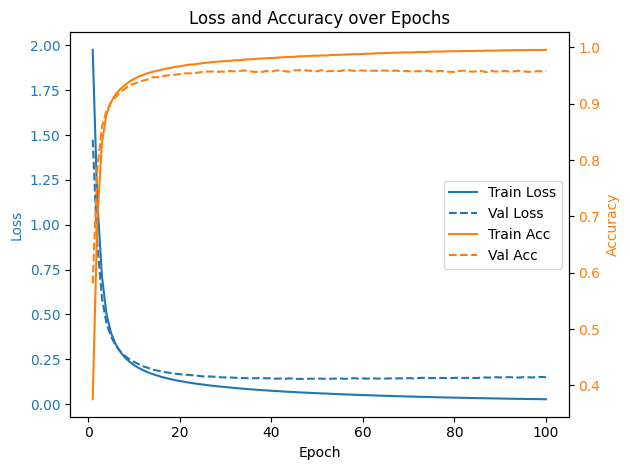

In [7]:
import matplotlib.pyplot as plt

# Load the trained model from file
model = MLP_Sigmoid().to(device)  # initialize model structure
checkpoint = torch.load("mlp_sigmoid_mnist.pth", map_location=device)
model.load_state_dict(checkpoint["model_state"])
history = checkpoint["history"]

model.eval()  # set to evaluation mode

# Prepare x-axis for plots
epochs = range(1, len(history["train_loss"]) + 1)

# Create figure and first axis (loss)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs, history["val_loss"], label="Val Loss", color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

# Second y-axis for accuracy
ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs, history["val_acc"], label="Val Acc", color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.title("Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()

#### Model Evaluation and Confusion Matrix

After training, we evaluate the model on the **unseen test set** to measure its generalization performance.  
The evaluation process follows these steps:

1. **Evaluation Mode** – We set the model to `eval()` mode so layers like dropout and batch normalization (if present) behave consistently and do not update during inference.
2. **No Gradient Tracking** – We wrap the test loop in `torch.no_grad()` to save memory and computation since we are not updating weights.
3. **Batch-wise Prediction** – For each batch from `test_loader`:
   - Move the data to the computation device (CPU/GPU/MPS).
   - Perform a forward pass to get raw scores (*logits*).
   - Take the class with the highest score as the prediction.
   - Store both predictions and true labels for later analysis.
4. **Accuracy Calculation** – We compare predictions to ground truth labels and compute the fraction of correct predictions.
5. **Confusion Matrix** – Using `sklearn.metrics.confusion_matrix`, we summarize how often each class was correctly predicted vs. misclassified.
   - Rows correspond to the **true class**.
   - Columns correspond to the **predicted class**.
   - Perfect classification would result in a diagonal matrix.
6. **Visualization** – We plot the confusion matrix as a heatmap to quickly see patterns of misclassification.

The confusion matrix is particularly useful for identifying **specific classes the model struggles with**, even when overall accuracy is high.

Test accuracy: 0.9598
Detected 10 classes: [0 1 2 3 4 5 6 7 8 9]


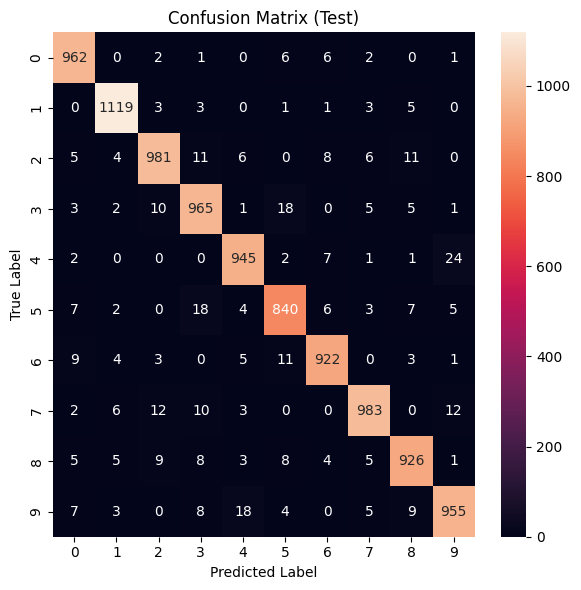

In [12]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the trained model from file
# Load the trained model from file
model = MLP_Sigmoid().to(device)  # initialize model structure
checkpoint = torch.load("mlp_sigmoid_mnist.pth", map_location=device)
model.load_state_dict(checkpoint["model_state"])

model.eval()  # set to evaluation mode

# Variables to track accuracy
test_correct, test_total = 0, 0

# Lists to store predictions and true labels for the confusion matrix
all_preds, all_trues = [], []

# Disable gradient computation for faster evaluation
with torch.no_grad():
    # Loop through the test set in batches
    for x, y in test_loader:
        # Move inputs to the computation device (CPU/GPU/MPS)
        x = x.to(device)
        
        # Forward pass to get raw model outputs (logits)
        logits = model(x)
        
        # Get predicted class indices (highest logit per sample)
        preds = logits.argmax(1).cpu().numpy()
        
        # Store predictions and ground truth labels for later
        all_preds.append(preds)
        all_trues.append(y.numpy())
        
        # Update accuracy counters
        test_correct += (preds == y.numpy()).sum()
        test_total   += y.size(0)

# Compute overall test accuracy
test_acc = test_correct / test_total
print(f"Test accuracy: {test_acc:.4f}")

# Flatten predictions and true labels into 1D arrays
y_true = np.concatenate(all_trues).ravel()
y_pred = np.concatenate(all_preds).ravel()

# Dynamically detect classes from both true and predicted
class_labels = np.unique(np.concatenate((y_true, y_pred)))
print(f"Detected {len(class_labels)} classes: {class_labels}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_labels)

# Plot annotated confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,              # annotate all cells
    fmt="d",                 # integer format
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#### Early Stopping and Best-Checkpoint Saving

When training neural networks, our goal is to find a model that **generalizes well** to unseen data—not one that simply memorizes the training set.  
If we train for too long, the model may begin to **overfit**, where:

- **Training loss** keeps decreasing.
- **Validation loss** starts to increase (performance on unseen data worsens).

**Early stopping** addresses this by:
- Monitoring the validation loss at the end of each epoch.
- Stopping training if it does not improve after a set number of epochs (`patience`).
- Preventing wasted computation time and avoiding overfitting.

**Best-checkpoint saving** goes a step further by:
- Saving the model whenever a **new best validation loss** is found.
- Ensuring that even if later epochs perform worse, we can restore the best version of the model.

This combination is important because:
- **Early stopping** prevents degradation of validation performance.
- **Best-checkpoint saving** guarantees that we do not lose the best weights.
- Both techniques are widely used in practice to produce **more reliable and efficient training outcomes**.

In [14]:
# ====================== RERUNNING CODE TO INITIALIZE MODEL =====================
model = MLP_Sigmoid().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
EPOCHS = 100

history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}
# ==============================================================================

# Early stopping settings
patience = 10          # epochs to wait after last improvement
min_delta = 0.0        # minimum change in val_loss to qualify as improvement
best_val = 10e20       # track best validation loss
best_epoch = -1
patience_ctr = 0
best_ckpt_path = "mlp_sigmoid_mnist_best.pt"

train_start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Training
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # Validation
    model.eval()
    val_running_loss, val_running_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_running_loss += loss.item() * x.size(0)
            val_running_correct += (logits.argmax(1) == y).sum().item()
            val_total += x.size(0)

    val_loss = val_running_loss / val_total
    val_acc  = val_running_correct / val_total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch:02d} | "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping check (monitor val_loss)
    if val_loss < best_val - min_delta:
        best_val = val_loss
        best_epoch = epoch
        patience_ctr = 0
        # Save best checkpoint so far
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history,
            "best_val_loss": best_val
        }, best_ckpt_path)
        print(f"  -> New best val_loss {best_val:.4f} at epoch {epoch}. Saved to {best_ckpt_path}.")
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch} "
                  f"(no improvement for {patience} epochs). Best epoch: {best_epoch}.")
            break

# Total training time
total_time = time.time() - train_start_time
print(f"\nTotal training time: {total_time:.2f}s")
print(f"Best epoch: {best_epoch} | Best val_loss: {best_val:.4f}")

# Restore best model before final save (in case we stopped after it)
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])

# Save final artifact (model + history)
final_path = "mlp_sigmoid_mnist_final.pth"
torch.save({
    "model_state": model.state_dict(),
    "history": history,
    "best_epoch": best_epoch,
    "best_val_loss": best_val
}, final_path)
print(f"Final model saved to '{final_path}'")

Epoch 01 | train: loss=2.0327, acc=0.3968 | val: loss=1.5499, acc=0.5556 | time: 2.13s
  -> New best val_loss 1.5499 at epoch 1. Saved to mlp_sigmoid_mnist_best.pt.
Epoch 02 | train: loss=1.1567, acc=0.7055 | val: loss=0.8717, acc=0.7984 | time: 2.21s
  -> New best val_loss 0.8717 at epoch 2. Saved to mlp_sigmoid_mnist_best.pt.
Epoch 03 | train: loss=0.7061, acc=0.8380 | val: loss=0.5934, acc=0.8594 | time: 2.22s
  -> New best val_loss 0.5934 at epoch 3. Saved to mlp_sigmoid_mnist_best.pt.
Epoch 04 | train: loss=0.5140, acc=0.8794 | val: loss=0.4686, acc=0.8830 | time: 2.13s
  -> New best val_loss 0.4686 at epoch 4. Saved to mlp_sigmoid_mnist_best.pt.
Epoch 05 | train: loss=0.4156, acc=0.8992 | val: loss=0.3975, acc=0.9002 | time: 2.15s
  -> New best val_loss 0.3975 at epoch 5. Saved to mlp_sigmoid_mnist_best.pt.
Epoch 06 | train: loss=0.3548, acc=0.9133 | val: loss=0.3517, acc=0.9078 | time: 2.13s
  -> New best val_loss 0.3517 at epoch 6. Saved to mlp_sigmoid_mnist_best.pt.
Epoch 07 |

#### Multi-GPU Training with Distributed Data Parallel (DDP)

**Goal:** Use all available CUDA GPUs to speed up training by running **one process per GPU** and synchronizing gradients.

**Key ideas**
- **One process per GPU.** DDP launches multiple worker processes; each owns a different GPU and a shard of the data.
- **Synchronized updates.** After each backward pass, gradients are **all-reduced** across workers so models stay in sync.
- **No duplicate data.** Use `DistributedSampler` so each worker sees a unique slice of the dataset each epoch.
- **Rank 0 only for I/O.** Print logs and save checkpoints only on **rank 0** to avoid duplicates.
- **Backend.** Use `nccl` on CUDA.

[1] Checking CUDA and listing devices...
    Found 2 CUDA device(s):
      [0] NVIDIA GeForce RTX 3080 Ti | 11.7 GB
      [1] NVIDIA GeForce RTX 3080 Ti | 11.7 GB
    Using primary device: cuda:0 (with 2 total GPUs)
    Wrapping model with DataParallel...
[2] Preparing MNIST datasets and dataloaders...
    Download/Load complete.
    Train/Val/Test sizes: 55000/5000/10000
    DataLoaders ready.
[3] Setting up loss and optimizer...
[4] Starting training...
    -> Epoch 01 starting...
       train: loss=2.0557, acc=0.3562 | val: loss=1.5788, acc=0.5840 | time: 2.43s
       New best val_loss 1.5788 at epoch 1. Saved checkpoint: mlp_mnist_dp_best.pth
    -> Epoch 02 starting...
       train: loss=1.1440, acc=0.7118 | val: loss=0.8376, acc=0.8010 | time: 2.43s
       New best val_loss 0.8376 at epoch 2. Saved checkpoint: mlp_mnist_dp_best.pth
    -> Epoch 03 starting...
       train: loss=0.6718, acc=0.8460 | val: loss=0.5722, acc=0.8646 | time: 2.42s
       New best val_loss 0.5722 at epoc

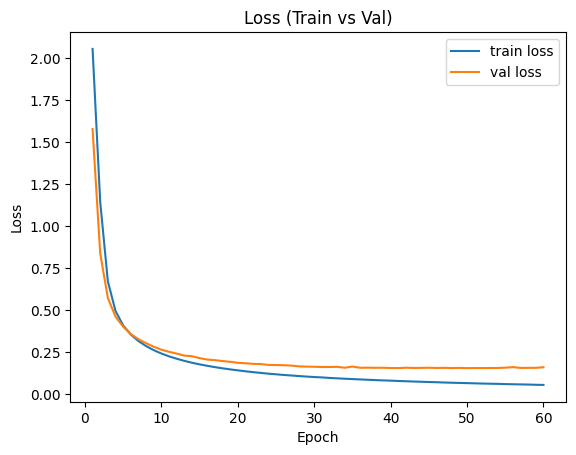

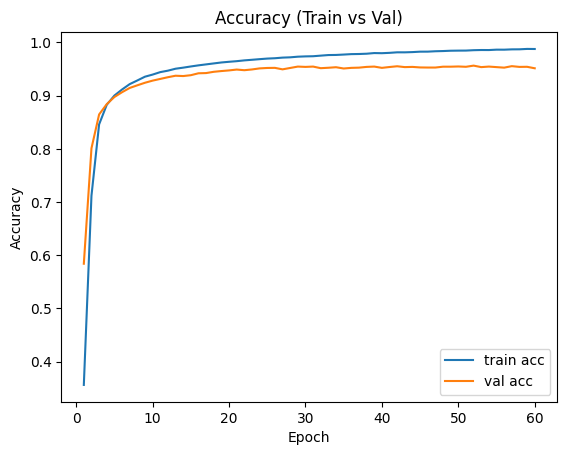

[7] Saving final artifact...
    Saved to mlp_mnist_dataparallel_final.pth


In [22]:
import os, time
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ======================================================================
# 1) GPU SETUP
# ======================================================================
print("[1] Checking CUDA and listing devices...")
if not torch.cuda.is_available():
    raise SystemExit("CUDA is not available — cannot proceed.")

num_gpus = torch.cuda.device_count()
print(f"    Found {num_gpus} CUDA device(s):")
for i in range(num_gpus):
    props = torch.cuda.get_device_properties(i)
    print(f"      [{i}] {props.name} | {props.total_memory / 1024**3:.1f} GB")

device_ids = list(range(num_gpus))
device = torch.device(f"cuda:{device_ids[0]}")
print(f"    Using primary device: {device} (with {len(device_ids)} total GPUs)")

model = MLP_Sigmoid().to(device)
if num_gpus > 1:
    print("    Wrapping model with DataParallel...")
    model = torch.nn.DataParallel(model, device_ids=device_ids)

torch.manual_seed(0)

# ======================================================================
# 2) DATA: TRANSFORMS, DATASETS, LOADERS
# ======================================================================
print("[2] Preparing MNIST datasets and dataloaders...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

root = "./data"
trainval = datasets.MNIST(root=root, train=True,  download=True, transform=transform)
testset  = datasets.MNIST(root=root, train=False, download=True, transform=transform)
print("    Download/Load complete.")

train_size = 55_000
val_size   = len(trainval) - train_size
trainset, valset = random_split(trainval, [train_size, val_size], generator=torch.Generator().manual_seed(42))

pin_mem = True
num_workers = min(4, os.cpu_count() or 0)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(valset,   batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"    Train/Val/Test sizes: {len(trainset)}/{len(valset)}/{len(testset)}")
print("    DataLoaders ready.")

# ======================================================================
# 3) LOSS, OPTIMIZER, HELPERS
# ======================================================================
print("[3] Setting up loss and optimizer...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

# ======================================================================
# 4) TRAINING WITH EARLY STOPPING
# ======================================================================
EPOCHS   = 100
patience = 10        # stop if no val_loss improvement for 'patience' epochs
min_delta = 0.0      # required improvement margin
best_val = float("inf")
best_epoch = -1
since_improved = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

print("[4] Starting training...")
train_start = time.time()
for epoch in range(1, EPOCHS + 1):
    print(f"    -> Epoch {epoch:02d} starting...")
    epoch_start = time.time()

    # Train
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # Validate
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss += loss.item() * x.size(0)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total += y.size(0)

    val_loss = v_loss / v_total
    val_acc  = v_correct / v_total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start
    print(f"       train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping
    if val_loss < best_val - min_delta:
        best_val = val_loss
        best_epoch = epoch
        since_improved = 0
        best_state = (model.module.state_dict()
                      if isinstance(model, torch.nn.DataParallel)
                      else model.state_dict())
        torch.save({
            "model_state": best_state,
            "history": history,
            "best_epoch": best_epoch,
            "best_val_loss": best_val
        }, "mlp_mnist_dp_best.pth")
        print(f"       New best val_loss {best_val:.4f} at epoch {epoch}. Saved checkpoint: mlp_mnist_dp_best.pth")
    else:
        since_improved += 1
        print(f"       No improvement ({since_improved}/{patience})")
        if since_improved >= patience:
            print(f"       Early stopping triggered. Best epoch: {best_epoch} (val_loss={best_val:.4f})")
            break

total_time = time.time() - train_start
print(f"[4] Training finished in {total_time:.2f}s | Best epoch: {best_epoch} | Best val_loss: {best_val:.4f}")

# ======================================================================
# 5) LOAD BEST, FINAL TEST
# ======================================================================
print("[5] Loading best checkpoint and evaluating on test set...")
ckpt = torch.load("mlp_mnist_dp_best.pth", map_location=device)
if isinstance(model, torch.nn.DataParallel):
    model.module.load_state_dict(ckpt["model_state"])
else:
    model.load_state_dict(ckpt["model_state"])

model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        test_correct += (preds == y).sum().item()
        test_total   += y.size(0)
test_acc = test_correct / test_total
print(f"    Test accuracy: {test_acc:.4f}")

# ======================================================================
# 6) PLOTS: TRAIN vs VAL
# ======================================================================
print("[6] Plotting metrics...")
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (Train vs Val)")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="train acc")
plt.plot(epochs, history["val_acc"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy (Train vs Val)")
plt.legend()
plt.show()

# ======================================================================
# 7) SAVE FINAL Model
# ======================================================================
print("[7] Saving final artifact...")

final_state = (model.module.state_dict()
               if isinstance(model, torch.nn.DataParallel)
               else model.state_dict())

torch.save({
    "model_state": final_state,
    "history": history,
    "best_epoch": best_epoch,
    "best_val_loss": best_val,
    "test_accuracy": test_acc
}, "mlp_mnist_dataparallel_final.pth")
print("    Saved to mlp_mnist_dataparallel_final.pth")

Although DDP did not speed this model up, it certainly will speed up training for larger models.

## Lecture 10 – Optimizers, Initializers, Vanishing Gradients, and Regularization

When we train a neural network, four core ideas often determine whether our model learns efficiently, converges to a good solution, and generalizes well to unseen data: the optimizer, how we initialize weights, how we handle vanishing gradients, and how we regularize our model to prevent overfitting.

### Optimizers

(More mathematical aspects are covered in the class lecture notes.)

The optimizer is the mechanism by which a neural network updates its parameters — the weights and biases — in order to minimize the loss function. Each optimizer takes the computed gradients from backpropagation and decides how to adjust the parameters. This choice has a major impact on the speed of convergence, the **stability of training, and the final accuracy.

The simplest approach is **Stochastic Gradient Descent (SGD)**, which updates parameters in the opposite direction of the gradient by a fixed learning rate. While efficient, plain SGD can be slow to converge and is prone to getting stuck in local minima. Adding **momentum** helps by incorporating a fraction of the previous update, smoothing the optimization path and allowing the network to push through shallow valleys.

More adaptive methods have emerged. **RMSProp** adjusts the learning rate for each parameter individually, scaling updates based on the recent magnitude of gradients, which makes it well-suited for problems where different parameters operate on different scales. **Adam**, one of the most widely used optimizers today, combines the benefits of momentum and RMSProp, using estimates of both the first and second moments of gradients. In practice, Adam often works well without extensive hyperparameter tuning, making it a strong default choice.

### Initializers
Before training even begins, the initial values of a network’s weights can have an outsized effect on the learning process. Poor initialization can cause gradients to either shrink toward zero (vanish) or grow uncontrollably (explode), making optimization difficult or impossible.

Setting all weights to zero is a nonstarter, as it causes all neurons in a layer to behave identically and learn the same features — a phenomenon known as the symmetry problem. Random initialization is essential to break symmetry, but the scale of randomness matters. **Xavier (Glorot) initialization** is designed to keep the variance of activations consistent across layers for sigmoid and tanh activations, while **He initialization** is tuned for ReLU and its variants, helping maintain stable signal variance through deeper networks. Choosing the right initializer reduces the risk of vanishing or exploding gradients from the outset.

### Vanishing Gradients
As networks grow deeper, one of the most notorious problems we face is the **vanishing gradient**. During backpropagation, gradients are propagated backward from the output layer toward the input. If these gradients become extremely small, the early layers receive almost no signal to update their weights, effectively halting learning.

Vanishing gradients often arise from activation functions like sigmoid or tanh, which saturate at extreme input values, producing very small derivatives. Poor initialization can also compound the problem — weights that are too small diminish the gradient signal, while weights that are too large can cause the opposite issue, **exploding gradients**.

Symptoms include early layers that stop updating, loss curves that plateau prematurely, and gradient norms that hover near zero. Solutions include using ReLU-family activations (such as ReLU, Leaky ReLU, or GELU), initializing weights appropriately (e.g., He initialization for ReLU networks), applying batch normalization to stabilize activation distributions, and using architectural changes such as residual connections to maintain gradient flow.

### Regularization
Even if our optimizer, initialization, and gradient flow are well-handled, a model that fits the training data too closely may fail to generalize to new inputs — the classic problem of **overfitting**. Regularization techniques aim to make models more robust by discouraging them from relying too heavily on any one set of weights or memorizing the training set.

Weight-based methods like **L1 regularization** encourage sparsity by penalizing the sum of absolute weight values, while **L2 regularization** (often called weight decay) penalizes the sum of squared weights, encouraging smaller and more evenly distributed values. **Dropout** is a stochastic approach that temporarily removes random neurons during training, forcing the network to build redundancy and preventing co-adaptation of features. Data-based approaches like **data augmentation** expand the diversity of the training set by applying transformations to the input samples. Finally, **early stopping** halts training when validation performance stops improving, preventing overfitting without altering the model architecture.

### PyTorch Examples

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[model] Initialized BetterMLP

[data] Preparing MNIST (train/val/test)...
[data] Sizes -> train: 55000, val: 5000, test: 10000

[train] Setup complete. Starting training...

[epoch 01] train: loss=0.2355, acc=0.9280 | val: loss=0.1325, acc=0.9596 | time: 2.13s
  [checkpoint] New best model saved.
[epoch 02] train: loss=0.1306, acc=0.9578 | val: loss=0.1188, acc=0.9664 | time: 2.22s
  [checkpoint] New best model saved.
[epoch 03] train: loss=0.1019, acc=0.9681 | val: loss=0.1133, acc=0.9680 | time: 2.19s
  [checkpoint] New best model saved.
[epoch 04] train: loss=0.0864, acc=0.9725 | val: loss=0.1457, acc=0.9696 | time: 2.17s
  [early-stop] No improvement (1/10)
[epoch 05] train: loss=0.0805, acc=0.9745 | val: loss=0.0779, acc=0.9752 | time: 2.22s
  [checkpoint] New best model saved.
[epoch 06] train: loss=0.0692, acc=0.9779 | val: loss=0.0742, acc=0.9776 | time: 2.16s
  [checkpoint] New best model saved.
[epoch 07] train: loss=0.0666

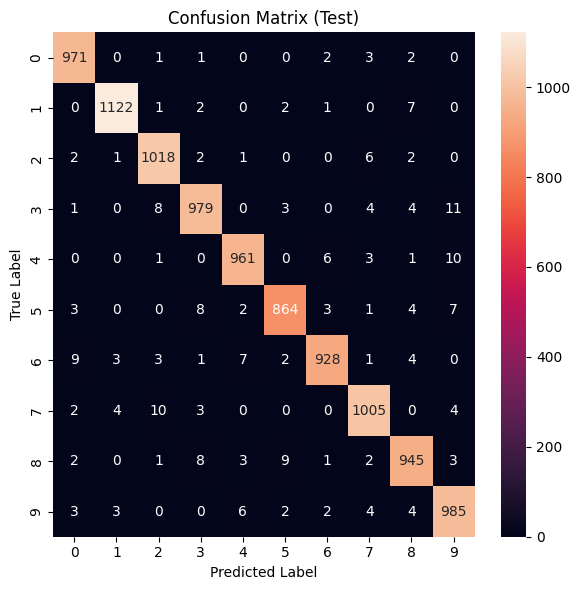

[eval] Classification report:

              precision    recall  f1-score   support

           0     0.9778    0.9908    0.9843       980
           1     0.9903    0.9885    0.9894      1135
           2     0.9760    0.9864    0.9812      1032
           3     0.9751    0.9693    0.9722      1010
           4     0.9806    0.9786    0.9796       982
           5     0.9796    0.9686    0.9741       892
           6     0.9841    0.9687    0.9763       958
           7     0.9767    0.9776    0.9772      1028
           8     0.9712    0.9702    0.9707       974
           9     0.9657    0.9762    0.9709      1009

    accuracy                         0.9778     10000
   macro avg     0.9777    0.9775    0.9776     10000
weighted avg     0.9778    0.9778    0.9778     10000


[plot] Plotting training curves...



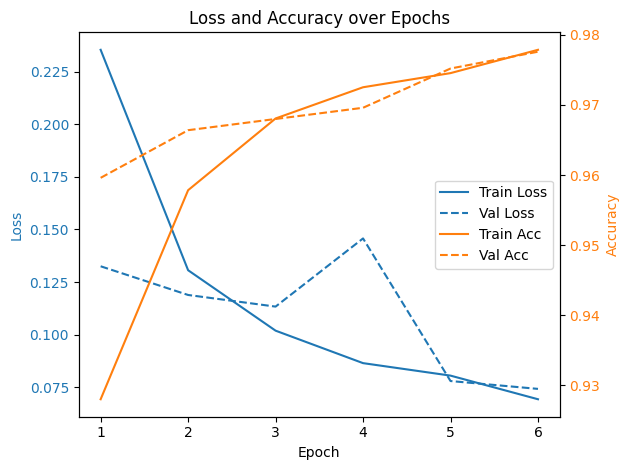

[done] Finished.



In [4]:
# ======================================================================
# 0) DEVICE SELECTION (CUDA -> MPS -> CPU) + SEED
# ======================================================================
import time, os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Device preference order: CUDA -> MPS -> CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[device] Using Apple Metal (MPS) device")
else:
    device = torch.device("cpu")
    print("[device] Using CPU")

torch.manual_seed(0)
print()  # line skip

# ======================================================================
# 1) MODEL DEFINITION: Better MLP (He init + BatchNorm + Dropout)
# ======================================================================
class BetterMLP(nn.Module):
    def __init__(self, in_dim=28*28, h1=512, h2=256, h3=128, out_dim=10, p_drop=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, h1),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h1),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h2),
            nn.Dropout(p_drop),

            nn.Linear(h2, h3),
            nn.ReLU(inplace=True),

            nn.Linear(h3, out_dim)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# Always start fresh
model = BetterMLP().to(device)
print("[model] Initialized BetterMLP")
print()  # line skip

# ======================================================================
# 2) DATA LOADING
# ======================================================================
print("[data] Preparing MNIST (train/val/test)...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

root = "./data"
trainval = datasets.MNIST(root=root, train=True,  download=True, transform=transform)
testset  = datasets.MNIST(root=root, train=False, download=True, transform=transform)

train_size = 55_000
val_size   = len(trainval) - train_size
trainset, valset = random_split(trainval, [train_size, val_size],
                                generator=torch.Generator().manual_seed(42))

pin_mem = (device.type == "cuda")
num_workers = min(4, os.cpu_count() or 0)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(valset,   batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"[data] Sizes -> train: {len(trainset)}, val: {len(valset)}, test: {len(testset)}")
print()  # line skip

# ======================================================================
# 3) TRAINING SETUP
# ======================================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

EPOCHS = 100
patience = 10
min_delta = 0.0
best_val = float("inf")
since_improved = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
print("[train] Setup complete. Starting training...")
print()  # line skip

# ======================================================================
# 4) TRAINING LOOP WITH EARLY STOPPING + TIMING
# ======================================================================
train_start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Training
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total          += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # Validation
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss    += loss.item() * x.size(0)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)

    val_loss = v_loss / v_total
    val_acc  = v_correct / v_total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"[epoch {epoch:02d}] "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping check
    if val_loss < best_val - min_delta:
        best_val = val_loss
        since_improved = 0
        torch.save({
            "model_state": model.state_dict(),
            "history": history
        }, "better_mlp_mnist.pth")
        print("  [checkpoint] New best model saved.")
    else:
        since_improved += 1
        print(f"  [early-stop] No improvement ({since_improved}/{patience})")
        if since_improved >= patience:
            print("  [early-stop] Patience exceeded — stopping.")
            break

total_train_time = time.time() - train_start_time
print(f"\n[train] Total training time: {total_train_time:.2f}s\n")

# Load best model
ckpt = torch.load("better_mlp_mnist.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
history = ckpt["history"]

# ======================================================================
# 5) EVALUATION ON TEST SET
# ======================================================================
print("[eval] Evaluating on test set...")
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(y.numpy())

y_true = np.concatenate(all_trues)
y_pred = np.concatenate(all_preds)
test_acc = (y_true == y_pred).mean()
print(f"[eval] Test accuracy: {test_acc:.4f}\n")

# Confusion Matrix (default colormap)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d")  # default cmap
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("[eval] Classification report:\n")
print(classification_report(y_true, y_pred, digits=4))
print()  # line skip

# ======================================================================
# 6) TRAIN/VAL LOSS + ACCURACY PLOT (Your Colors)
# ======================================================================
print("[plot] Plotting training curves...\n")
epochs_range = range(1, len(history["train_loss"]) + 1)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs_range, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs_range, history["val_loss"],   label="Val Loss",   color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs_range, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs_range, history["val_acc"],   label="Val Acc",   color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.title("Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()

print("[done] Finished.\n")

### CIFAR10 Experiments

Next, let's try a more challenging dataset: CIFAR-10.

[device] Using CUDA GPU: NVIDIA GeForce RTX 3080 Ti

[model] Initialized CIFAR10_MLP

[data] Preparing CIFAR-10 (train/val/test)...


100%|██████████| 170498071/170498071 [00:33<00:00, 5133156.59it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
[data] Sizes -> train: 45000, val: 5000, test: 10000

[train] Setup complete. Starting training...

[epoch 001] train: loss=2.0215, acc=0.3479 | val: loss=1.6441, acc=0.4588 | time: 2.42s
  [checkpoint] New best model saved (val_acc).
[epoch 002] train: loss=1.7437, acc=0.4221 | val: loss=1.5668, acc=0.4924 | time: 2.46s
  [checkpoint] New best model saved (val_acc).
[epoch 003] train: loss=1.6481, acc=0.4552 | val: loss=1.5137, acc=0.5012 | time: 2.45s
  [checkpoint] New best model saved (val_acc).
[epoch 004] train: loss=1.5774, acc=0.4763 | val: loss=1.4927, acc=0.5092 | time: 2.42s
  [checkpoint] New best model saved (val_acc).
[epoch 005] train: loss=1.5210, acc=0.5004 | val: loss=1.4428, acc=0.5352 | time: 2.47s
  [checkpoint] New best model saved (val_acc).
[epoch 006] train: loss=1.4721, acc=0.5215 | val: loss=1.4400, acc=0.5328 | time: 2.44s
  [early-stop] No improvement (1/10)
[epoch 00

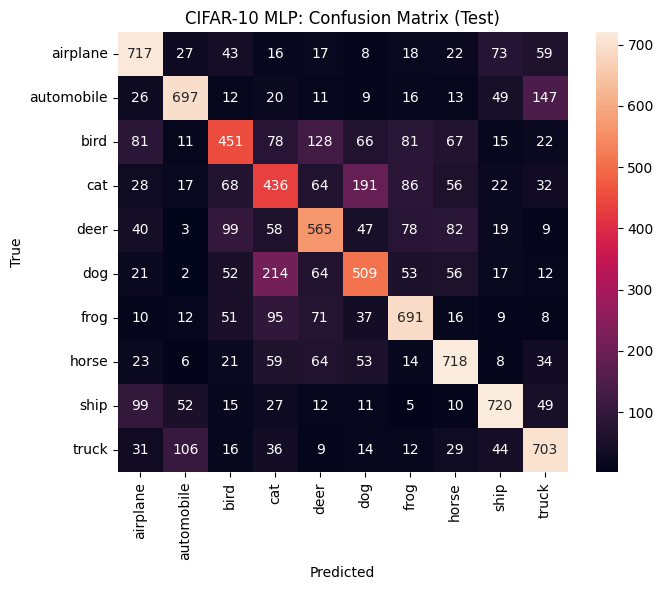

[eval] Classification report:

              precision    recall  f1-score   support

    airplane     0.6664    0.7170    0.6908      1000
  automobile     0.7471    0.6970    0.7212      1000
        bird     0.5447    0.4510    0.4934      1000
         cat     0.4196    0.4360    0.4277      1000
        deer     0.5622    0.5650    0.5636      1000
         dog     0.5386    0.5090    0.5234      1000
        frog     0.6556    0.6910    0.6728      1000
       horse     0.6717    0.7180    0.6941      1000
        ship     0.7377    0.7200    0.7287      1000
       truck     0.6540    0.7030    0.6776      1000

    accuracy                         0.6207     10000
   macro avg     0.6197    0.6207    0.6193     10000
weighted avg     0.6197    0.6207    0.6193     10000


[plot] Plotting training curves...



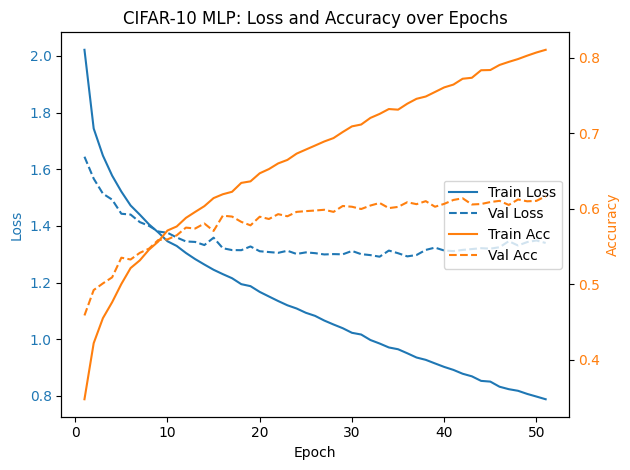

[done] Finished.



In [9]:
# ======================================================================
# 0) DEVICE SELECTION (CUDA -> MPS -> CPU) + SEED
# ======================================================================
import time, os
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Device preference order
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[device] Using CUDA GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[device] Using Apple Metal (MPS) device")
else:
    device = torch.device("cpu")
    print("[device] Using CPU")

torch.manual_seed(0)
print()  # line skip

# ======================================================================
# 1) MODEL: MLP for CIFAR-10 (flatten 32x32x3=3072)
#    ReLU + He init + BatchNorm + Dropout
#    Architecture chosen for good MLP baseline on CIFAR-10.
# ======================================================================
class CIFAR10_MLP(nn.Module):
    def __init__(self, in_dim=32*32*3, h1=2048, h2=1024, h3=512, out_dim=10, p_drop=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                       # (N, 3, 32, 32) -> (N, 3072)

            nn.Linear(in_dim, h1),              # 3072 -> 2048
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h1),
            nn.Dropout(p_drop),

            nn.Linear(h1, h2),                  # 2048 -> 1024
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h2),
            nn.Dropout(p_drop),

            nn.Linear(h2, h3),                  # 1024 -> 512
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(h3),
            nn.Dropout(p_drop * 0.5),

            nn.Linear(h3, out_dim)              # logits (512 -> 10)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight); nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

# Always start fresh
model = CIFAR10_MLP().to(device)
print("[model] Initialized CIFAR10_MLP")
print()  # line skip

# ======================================================================
# 2) DATA: CIFAR-10 normalization (augmentation optional/minimal for MLP)
# ======================================================================
print("[data] Preparing CIFAR-10 (train/val/test)...")
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

# For an MLP, heavy spatial augmentation is less impactful; keep it simple
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),   # mild augmentation
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

root = "../data"
full_train = datasets.CIFAR10(root=root, train=True,  download=True, transform=train_tf)
testset    = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)

# Train/Val split (45k/5k)
train_size = 45000
val_size   = len(full_train) - train_size
trainset, valset = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

pin_mem = (device.type == "cuda")
num_workers = min(4, os.cpu_count() or 0)
train_loader = DataLoader(trainset, batch_size=256, shuffle=True,  num_workers=num_workers, pin_memory=pin_mem)
val_loader   = DataLoader(valset,   batch_size=512, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)
test_loader  = DataLoader(testset,  batch_size=512, shuffle=False, num_workers=num_workers, pin_memory=pin_mem)

print(f"[data] Sizes -> train: {len(trainset)}, val: {len(valset)}, test: {len(testset)}")
print()  # line skip

# ======================================================================
# 3) TRAINING SETUP
# ======================================================================
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # small smoothing helps MLP on CIFAR-10
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)

def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

EPOCHS = 100
patience = 10
min_delta = 0.0
best_val = 0.0
since_improved = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
print("[train] Setup complete. Starting training...")
print()  # line skip

# ======================================================================
# 4) TRAINING LOOP WITH EARLY STOPPING + TIMING
# ======================================================================
train_start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    # Train
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total          += x.size(0)

    train_loss = running_loss / total
    train_acc  = running_correct / total

    # Validate
    model.eval()
    v_loss, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            v_loss    += loss.item() * x.size(0)
            v_correct += (logits.argmax(1) == y).sum().item()
            v_total   += y.size(0)

    val_loss = v_loss / v_total
    val_acc  = v_correct / v_total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"[epoch {epoch:03d}] "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

    # Early stopping on val_acc instead of val_loss
    if val_acc > best_val + min_delta:   # note: 'best_val' now tracks accuracy
        best_val = val_acc
        since_improved = 0
        torch.save({"model_state": model.state_dict(), "history": history}, "cifar10_mlp_best.pth")
        print("  [checkpoint] New best model saved (val_acc).")
    else:
        since_improved += 1
        print(f"  [early-stop] No improvement ({since_improved}/{patience})")
        if since_improved >= patience:
            print("  [early-stop] Patience exceeded — stopping.")
            break

total_train_time = time.time() - train_start_time
print(f"\n[train] Total training time: {total_train_time:.2f}s\n")

# Load best model
ckpt = torch.load("cifar10_mlp_best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
history = ckpt["history"]

# ======================================================================
# 5) EVALUATION ON TEST SET + CONFUSION MATRIX + REPORT
# ======================================================================
print("[eval] Evaluating on CIFAR-10 test set...")
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_trues.append(y.numpy())

y_true = np.concatenate(all_trues).ravel()
y_pred = np.concatenate(all_preds).ravel()
classes = testset.classes  # CIFAR-10 class names
test_acc = (y_true == y_pred).mean()
print(f"[eval] Test accuracy: {test_acc:.4f}\n")

# Confusion Matrix (default cmap)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)  # default colormap
plt.title("CIFAR-10 MLP: Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print("[eval] Classification report:\n")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))
print()  # line skip

# ======================================================================
# 6) TRAIN/VAL LOSS + ACCURACY PLOT (tab:blue / tab:orange)
# ======================================================================
print("[plot] Plotting training curves...\n")
epochs_range = range(1, len(history["train_loss"]) + 1)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs_range, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs_range, history["val_loss"],   label="Val Loss",   color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs_range, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs_range, history["val_acc"],   label="Val Acc",   color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")

plt.title("CIFAR-10 MLP: Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()

print("[done] Finished.\n")
